<h3><center>Evaluacion 4 - IMA539.</center></h3>
<center>Simón Fonseca, Natalia Deumacán, Benjamín González.</center>

<center>10 de Diciembre del 2023.</center>


***
### Librerías y útiles

In [1]:
# default
import os

# pip
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# torch
import torch
import torchvision
from torchvision.io import ImageReadMode
from torch import nn
#from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

<h1><center>Pregunta 1.</center></h1>

In [2]:
# Carpeta raiz de todo el dataset
root = 'BD_perros'

# Paths and labels
img_paths = []
img_class = []
i = 0

# For every dir in root
for class_dir in os.listdir(root):
    # Path to dir in root
    class_dir_path = os.path.join(root, class_dir)

    # Get every element in the dir
    elems = [os.path.join(class_dir_path, x) 
                for x in os.listdir(class_dir_path) 
                if x != '.DS_Store']
    # Add image path
    img_paths.extend(elems)

    # -------------------------
    # Treatment for pair labels
    # -------------------------
    img_class.extend([i for _ in range(len(elems))])
    i += 1

# Verificación
classes, counts = np.unique(img_class, return_counts= True)
print('class | counts')
print('--------------')
_ = [print('{:5n} | {:n}'.format(x, y)) for x, y in zip(classes, counts)]

class | counts
--------------
    0 | 208
    1 | 247
    2 | 213
    3 | 182
    4 | 180


In [3]:
img_path_idxs = list(range(len(img_paths)))
batch_size = 64

# Train+Validation / Test
X_train_val, X_test, y_train_val, y_test = train_test_split(img_path_idxs, img_class, test_size=0.3, random_state=42, stratify= img_class)

<h1><center>Pregunta 2.</center></h1>

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, paths, labels, split_indexes):
        # Indexes of the split
        self.split_indexes = split_indexes
        # Only elements of that split
        self.paths = np.array(paths)[split_indexes]
        self.labels = np.array(labels)[split_indexes]

    def __len__(self):
        return len(self.split_indexes)

    def __getitem__(self, idx):
        image = torchvision.io.read_image(self.paths[idx], ImageReadMode.RGB).float()
        label = torch.tensor(self.labels[idx],dtype=torch.long)
        return image, label

Implementación del modelo.

In [5]:
# Constructor
model = nn.Sequential()

# Conv -> ReLU -> MaxPooling
model.add_module('conv1', nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 5, padding= 2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size= 2))

# Conv -> ReLU -> MaxPooling
model.add_module('conv2', nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 5, padding= 2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size= 2))

# Flatten
model.add_module('flatten', nn.Flatten())

# Full Connected -> ReLU -> Dropout
model.add_module('fc1', nn.Linear(200704, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p= .5))

# Full Connected
model.add_module('fc2', nn.Linear(1024, 5))
#model.add_module('soft', nn.Softmax(dim=10))

In [6]:
# Selección de dispositivo
if torch.cuda.is_available(): 
    processing_unit = 'cuda'
elif torch.backends.mps.is_built():
    processing_unit = 'mps'
else:
    processing_unit = 'cpu'
device = torch.device(processing_unit)

# Pesos del modelo al dispositivo
model.to(device)

print(f"You're using: {device} as device.")

You're using: cuda as device.


### Entrenamiento

In [7]:
# Función de costo: CrossEntropy
loss_fn = nn.CrossEntropyLoss()

# Optimizador: ADAM
optimizer = torch.optim.Adam(model.parameters(), lr= .001)

Función de entrenamiento

In [8]:
def train(model, num_epochs, train_dl, valid_dl, device):
    # Perdida y exactitud en entrenamiento
    loss_hist_train = torch.zeros(num_epochs).to(device)
    accuracy_hist_train = torch.zeros(num_epochs).to(device)
    # Perdida y exactitud en validación
    loss_hist_valid = torch.zeros(num_epochs).to(device)
    accuracy_hist_valid = torch.zeros(num_epochs).to(device)

    # Por cada época
    for epoch in range(num_epochs):
        # Modelo en modo entrenamiento
        model.train()
        with tqdm(train_dl, unit="batch") as tepoch:
            # Por batch en el conjunto de entrenamiento
            for x_batch, y_batch in tepoch:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                # Predicciones del modelo
                pred = model(x_batch)
                # Pérdida del modelo
                loss = loss_fn(pred, y_batch)
                # Paso hacia atrás
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Guarda pérdida en entrenamiento
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)
                # Cantidad de muestras predichas correctamente
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                # Guarda exactitud
                accuracy_hist_train[epoch] += is_correct.sum()
                tepoch.set_postfix(batch_loss= loss.item(),
                                   batch_accuracy= 100. * is_correct.sum().item() / y_batch.size(0))
            # Promedio por época en todos los batches
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # Modelo en modo evaluación
        model.eval()
        with tqdm(valid_dl, unit="batch") as vepoch:
            # Pesos congelados
            with torch.no_grad():
                # Por batch en el conjunto de validación
                for x_batch, y_batch in vepoch:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    # Predicciones
                    pred = model(x_batch)
                    # Pérdida
                    loss = loss_fn(pred, y_batch)
                    # Guarda pérdia en validación
                    loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                    # Cantidad de muestras predichas correctamente
                    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                    # Guarda exactitud
                    accuracy_hist_valid[epoch] += is_correct.sum()
                    vepoch.set_postfix(batch_loss= loss.item(),
                                       batch_accuracy= 100. * is_correct.sum().item() / y_batch.size(0))
            # Promedio por época en todos los batches
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    return loss_hist_train.cpu(), loss_hist_valid.cpu(), accuracy_hist_train.cpu(), accuracy_hist_valid.cpu()

Entrenamiento

In [9]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Parámetros de la capa {layer} reseteados')
    layer.reset_parameters()

In [10]:
from sklearn.model_selection import StratifiedKFold

if not os.path.exists("./folds"):
    os.makedirs("./folds")

skf = StratifiedKFold(n_splits=5)

img_path_idxs = np.array(range(len(img_paths)))
img_class = np.array(img_class)

test_ds = CustomImageDataset(img_paths, img_class, X_test)

H = []
for fold, (train_index, val_index) in enumerate(skf.split(X_train_val, y_train_val)):
    print('----------------------------------------------------------------')
    print(f'FOLD {fold+1}')
    print('----------------------------------------------------------------')
    
    X_train = img_path_idxs[train_index]
    X_val = img_path_idxs[val_index]
        
    # Datasets
    train_ds = CustomImageDataset(img_paths, img_class, X_train)
    valid_ds = CustomImageDataset(img_paths, img_class, X_val)

    # DataLoaders
    batch_size = 64
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle= True)
    valid_dl = DataLoader(valid_ds, batch_size= batch_size, shuffle= False)
    
    torch.manual_seed(1)
    num_epochs = 5
    hist = train(model, num_epochs, train_dl, valid_dl, device)
    
    save_path = f'./folds/model-fold-{fold+1}.pth'
    torch.save(model.state_dict(), save_path)
    
    H.append(hist)
    model.apply(reset_weights)

----------------------------------------------------------------
FOLD 1
----------------------------------------------------------------


100%|██████████| 3/3 [00:00<00:00, 13.71batch/s, batch_accuracy=0, batch_loss=2.49]


Parámetros de la capa Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Linear(in_features=200704, out_features=1024, bias=True) reseteados
Parámetros de la capa Linear(in_features=1024, out_features=5, bias=True) reseteados
----------------------------------------------------------------
FOLD 2
----------------------------------------------------------------


100%|██████████| 3/3 [00:00<00:00, 13.09batch/s, batch_accuracy=37.5, batch_loss=2.03]


Parámetros de la capa Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Linear(in_features=200704, out_features=1024, bias=True) reseteados
Parámetros de la capa Linear(in_features=1024, out_features=5, bias=True) reseteados
----------------------------------------------------------------
FOLD 3
----------------------------------------------------------------


100%|██████████| 3/3 [00:00<00:00,  8.46batch/s, batch_accuracy=37.5, batch_loss=1.17]


Parámetros de la capa Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Linear(in_features=200704, out_features=1024, bias=True) reseteados
Parámetros de la capa Linear(in_features=1024, out_features=5, bias=True) reseteados
----------------------------------------------------------------
FOLD 4
----------------------------------------------------------------


100%|██████████| 3/3 [00:00<00:00,  7.47batch/s, batch_accuracy=18.8, batch_loss=2.6] 


Parámetros de la capa Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Linear(in_features=200704, out_features=1024, bias=True) reseteados
Parámetros de la capa Linear(in_features=1024, out_features=5, bias=True) reseteados
----------------------------------------------------------------
FOLD 5
----------------------------------------------------------------


100%|██████████| 3/3 [00:00<00:00,  7.44batch/s, batch_accuracy=0, batch_loss=6.82]   


Parámetros de la capa Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) reseteados
Parámetros de la capa Linear(in_features=200704, out_features=1024, bias=True) reseteados
Parámetros de la capa Linear(in_features=1024, out_features=5, bias=True) reseteados


Curvas de aprendizaje

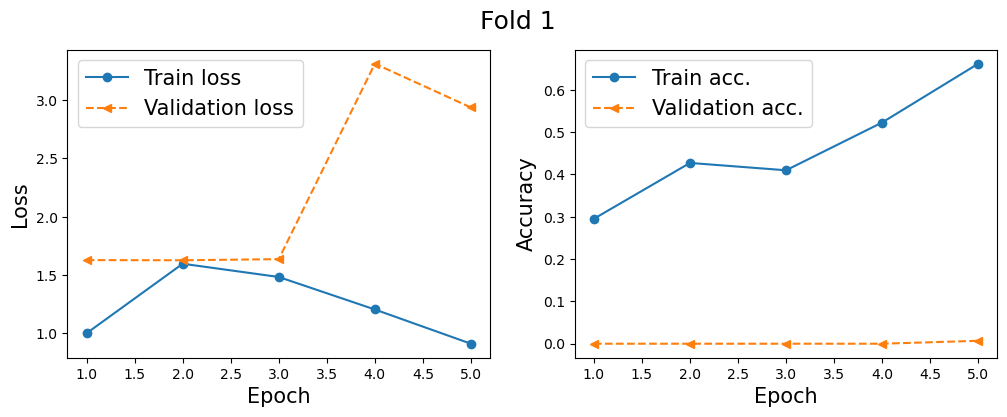

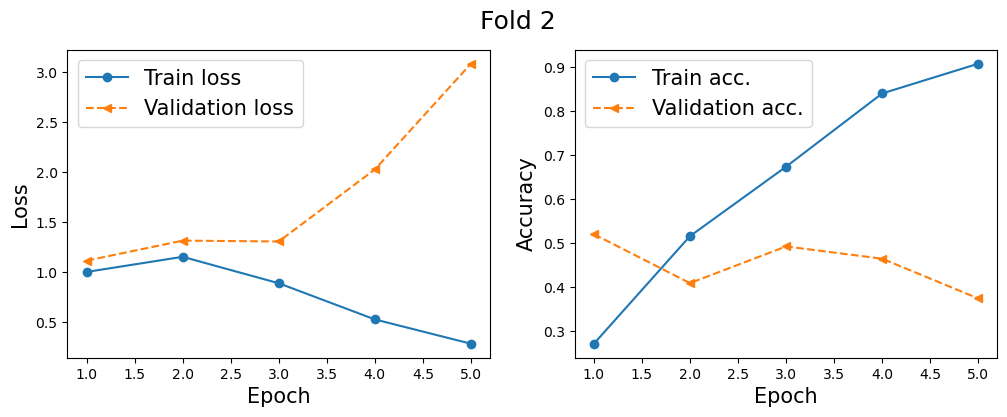

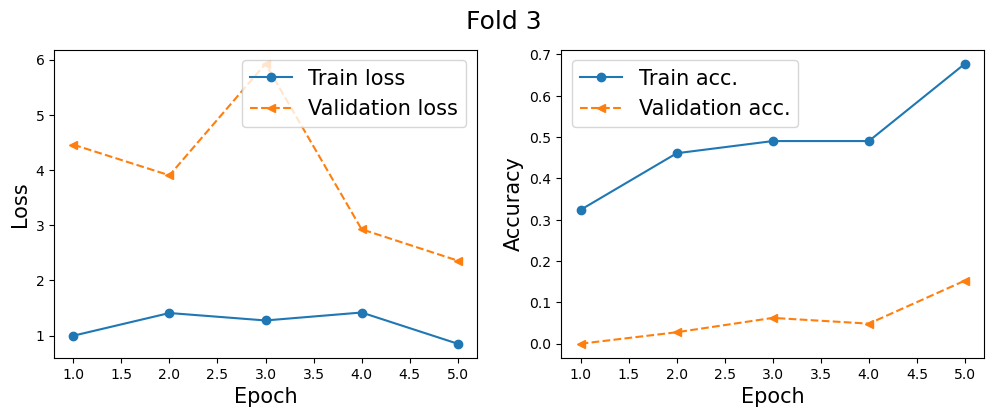

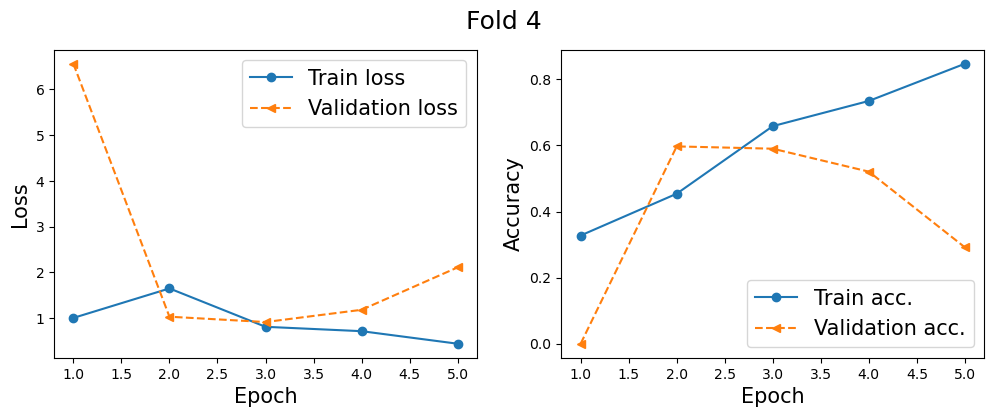

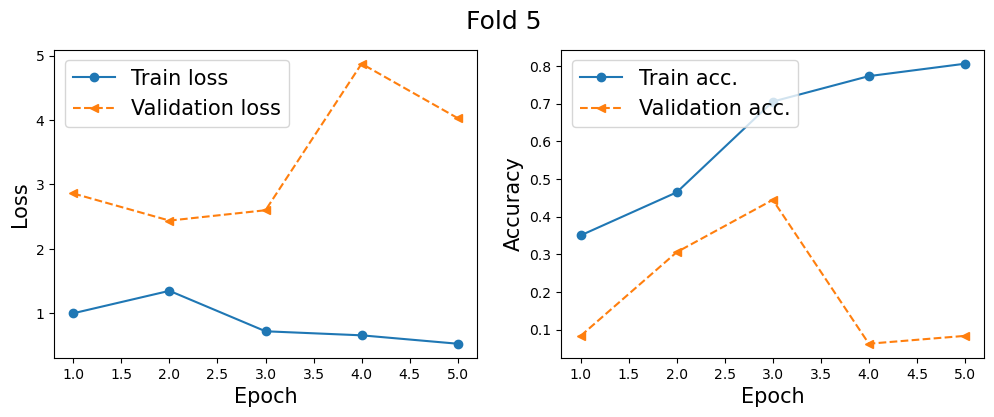

In [11]:
# El primer valor de pérdida en el conjunto de entrenamiento suele dar valores muy altos, aquí lo limitamos a 1 para que los gráficos sean legibles
histTotal = H
for i in range(len(H)):
    histTotal[i][0][0] = 1

for i in range(len(H)):
    x_arr = np.arange(len(histTotal[i][0])) + 1
    fig = plt.figure(figsize= (12, 4))
    fig.suptitle('Fold ' + str(i+1), size=18)
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, histTotal[i][0], '-o', label='Train loss')
    ax.plot(x_arr, histTotal[i][1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, histTotal[i][2], '-o', label='Train acc.')
    ax.plot(x_arr, histTotal[i][3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

Evaluación en testeo

In [12]:
suma = 0.0
accuracy = {}

for fold in range(len(H)):
    test_imgs = torch.stack([test_ds[i][0] for i in range(len(test_ds))]).to(device)  
    load_path = f'./folds/model-fold-{fold+1}.pth'
    
    # Etiqueta real
    test_real_class = torch.stack([test_ds[i][1] for i in range(len(test_ds))]).to(device)
    
    model.load_state_dict(torch.load(load_path))
    
    predictions = model(test_imgs)
    del test_imgs
    # Predicciones a categórica
    test_pred_class = torch.argmax(predictions, dim= 1)
    del predictions

    is_correct = (test_pred_class == test_real_class).float()
    accuracy[fold] = is_correct.mean()
    suma = suma + accuracy[fold]
    
    print(f'Fold: {fold+1}')
    print(f'Test accuracy: {accuracy[fold]:.4f}')
    print('------------------------------')
    
print(f'Test accuracy promedio: {suma/len(H):.4f}')

Fold: 1
Test accuracy: 0.4337
------------------------------
Fold: 2
Test accuracy: 0.6149
------------------------------
Fold: 3
Test accuracy: 0.4175
------------------------------
Fold: 4
Test accuracy: 0.5599
------------------------------
Fold: 5
Test accuracy: 0.4725
------------------------------
Test accuracy promedio: 0.4997


Subset de imágenes y su predicción

In [13]:
num_to_class = {0: 'french bulldog', 1: 'german sheperd',
                2: 'golden retriever', 3: 'poodle',
                4: 'yorkshire terrier',}

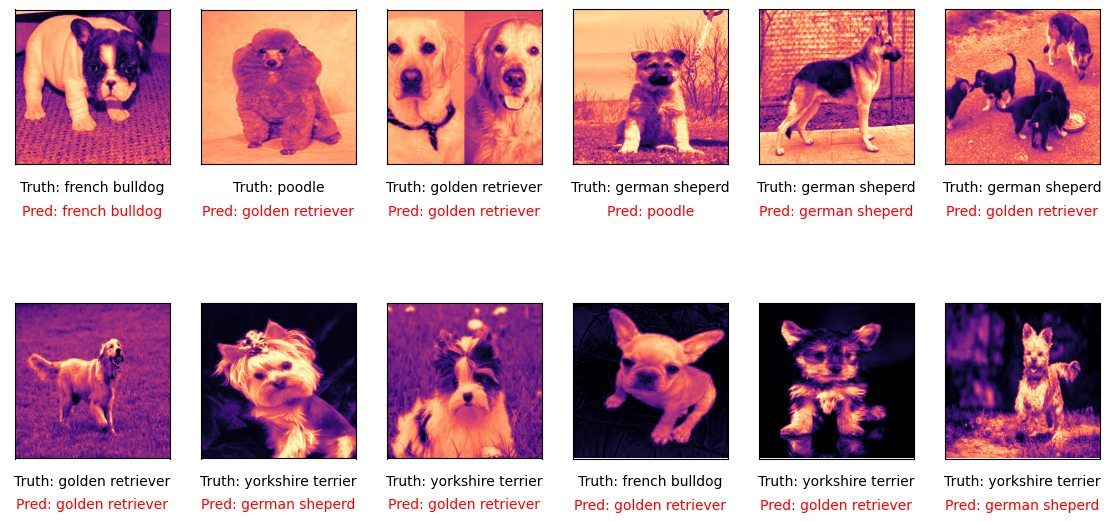

In [14]:
mejor_fold = max(accuracy, key=accuracy.get)
load_path = f'./folds/model-fold-{mejor_fold+1}.pth'

model.load_state_dict(torch.load(load_path))

# Imágenes en testeo
imgs = torch.stack([test_ds[i][0] for i in range(12)]).to(device)
preds = torch.argmax(model(imgs), dim=1)
txt_class = [num_to_class[x.item()] for x in preds.cpu()]

fig = plt.figure(figsize=(14, 7))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Obtener la imagen en formato numpy
    img = imgs[i][0].cpu().numpy()

    # Mostrar la imagen con el colormap 'magma'
    ax.imshow(img, cmap='magma')

    # Texto con la etiqueta de la verdad y la predicción
    true_label = num_to_class[test_ds[i][1].item()]
    pred_label = txt_class[i]

    ax.text(.5, -.15, f'Truth: {true_label}', size=10, color='black',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)

    ax.text(.5, -.3, f'Pred: {pred_label}', size=10, color='red',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)

plt.show()


El modelo presenta bajo ajuste, esto puede deberse a:
- La precisión del conjunto de validación fue deficiente.
- La cantidad de imágenes podría ser insuficiente para entrenar un modelo, siendo complejo que pueda diferenciar claramente patrones específicos de las razas de perros.

<h1><center>Pregunta 3.</center></h1>

## Pregunta 3.1

Elige mejor fold

In [15]:
mejor_fold = max(accuracy, key=accuracy.get)
load_path = f'./folds/model-fold-{mejor_fold+1}.pth'

print(f'El mejor fold es el: {mejor_fold+1}')

El mejor fold es el: 2


In [16]:
from sklearn.metrics import confusion_matrix

test_imgs = torch.stack([test_ds[i][0] for i in range(len(test_ds))]).to(device)  

y_pred = torch.argmax(model(test_imgs), dim=1)
y_test = torch.stack([test_ds[i][1] for i in range(len(test_ds))]).to(device)

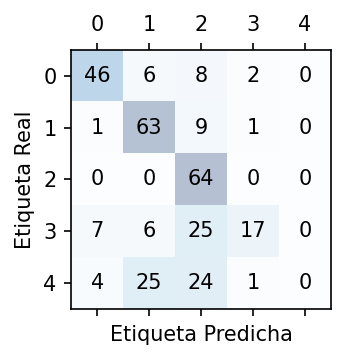

In [17]:
confmat = confusion_matrix(y_true=y_test.cpu().numpy(), y_pred=y_pred.cpu())

fig, ax = plt.subplots(figsize=(2.5, 2.5),dpi=150)
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [18]:
c = np.trace(confmat)
s = np.sum(confmat)
pk = np.sum(confmat, axis=0)
tk = np.sum(confmat, axis=1)

# MCC
mcc_n = c * s - np.sum(pk * tk)
mcc_d = np.sqrt((s**2 - np.sum(pk**2)) * (s**2 - np.sum(tk**2)))
mcc = mcc_n / mcc_d if mcc_d != 0 else 0

# Kappa
kappa_n = c * s - np.sum(pk * tk)
kappa_d = s**2 - np.sum(pk * tk)
kappa = kappa_n / kappa_d if kappa_d != 0 else 0

#ACC
acc=c/s

print(f"Coeficiente de Correlacion de Matthews (MCC): {mcc:.4f}")
print(f"Cohen’s Kappa coefficient (Kappa): {kappa:.4f}")
print(f"Exactitud: {acc:.4f}")

Coeficiente de Correlacion de Matthews (MCC): 0.5446
Cohen’s Kappa coefficient (Kappa): 0.5098
Exactitud: 0.6149


## Pregunta 3.2

In [19]:
import torchsummary
torchsummary.summary(model,input_data= torch.randint(0, 255, (batch_size, 3, 224, 224))/ 255,
col_names=["output_size", "num_params"], verbose= 0,device= device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 224, 224]        2,432
├─ReLU: 1-2                              [-1, 32, 224, 224]        --
├─MaxPool2d: 1-3                         [-1, 32, 112, 112]        --
├─Conv2d: 1-4                            [-1, 64, 112, 112]        51,264
├─ReLU: 1-5                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-6                         [-1, 64, 56, 56]          --
├─Flatten: 1-7                           [-1, 200704]              --
├─Linear: 1-8                            [-1, 1024]                205,521,920
├─ReLU: 1-9                              [-1, 1024]                --
├─Dropout: 1-10                          [-1, 1024]                --
├─Linear: 1-11                           [-1, 5]                   5,125
Total params: 205,580,741
Trainable params: 205,580,741
Non-trainable params: 0
Total mult-adds (M): 968.20
Input size (MB): 36.75
Forwa

In [20]:
32*(3*5*5+1)

2432

In [21]:
64*(32*5*5+1)

51264

In [22]:
200704*1024+1024

205521920

In [23]:
1024*5+5

5125

- La primera capa convolución 2D recibe 3 capas de entrada y devuelve 32 de salida, además tiene un kernel de tamaño 5, por lo que tendrá 2432 parámetros.
- La segunda capa convolución recibe 32 capas y devuelve 64 de salida, dando 51264 parámetros.
- La primera capa lineal conecta 200704 neuronas de entrada con 1024 de salida, por lo que tendrá 205521920 parámetros.
- Y por último, la segunda capa lineal conecta 1024 neuronas a las 5 categorías de salida, dando así un total de 5125 parámetros.